![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()
bikes.season.describe()

count    10886.000000
mean         2.506614
std          1.116174
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: season, dtype: float64

Podemos inferir que la mayoría de las observaciones en el conjunto de datos de Capital Bikeshare pertenecen a la temporada de primavera, verano y otoño, y que la variable "season" es una variable categórica con cuatro posibles valores. La media es de 2.506614, lo que indica que hay más observaciones en primavera y verano que en invierno y otoño. La desviación estándar es de 1.116174, lo que sugiere que la distribución de la variable "season" está bastante dispersa y que hay una variación significativa en el número de alquileres de bicicletas en diferentes estaciones.

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()
bikes.hour.describe()

count    10886.000000
mean        11.541613
std          6.915838
min          0.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64

Podemos inferir que la variable "hour" en este conjunto de datos representa la hora del día en que se alquiló la bicicleta, y que hay una distribución uniforme de los alquileres de bicicletas a lo largo del día. El valor medio de 11.541613 sugiere que hay una distribución uniforme de los alquileres de bicicletas a lo largo del día, aunque es posible que haya algunas horas pico durante el día. Los valores de cuartil también sugieren una distribución uniforme, con el 25% de las observaciones cayendo en las primeras 6 horas del día, el 50% en las primeras 12 horas del día y el 75% en las primeras 18 horas del día.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

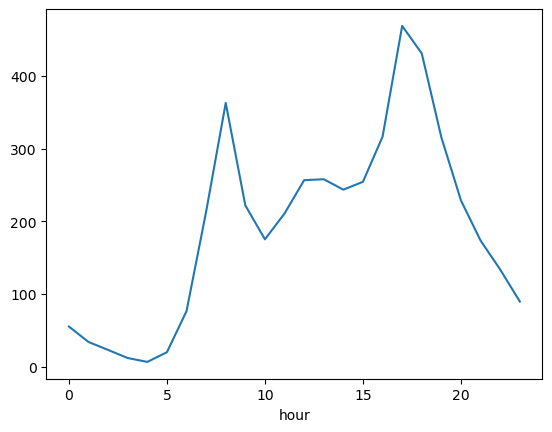

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

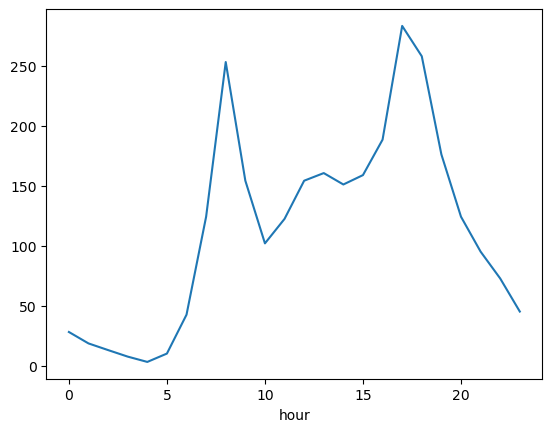

In [7]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes.season == 1].groupby('hour').total.mean().plot()

Al analizar la gráfica, podemos ver que hay dos picos de alquileres de bicicletas durante el día: uno en la mañana, alrededor de las 8:00 am, y otro en la tarde, alrededor de las 5:00 pm. Estos picos sugieren que las personas pueden estar utilizando las bicicletas para desplazarse al trabajo o la escuela. También podemos ver que hay un período de tiempo durante la noche, desde alrededor de las 9:00 pm hasta las 4:00 am, donde el número de bicicletas alquiladas es muy bajo, por las bajs temperaturas.

<Axes: xlabel='hour'>

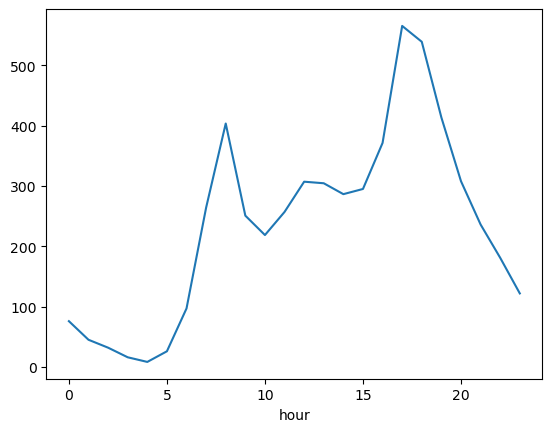

In [8]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes.season == 3].groupby('hour').total.mean().plot()

Al analizar la gráfica, podemos ver que hay un pico de alquileres de bicicletas durante el día, alrededor de las 5:00 pm. Esto sugiere que las personas pueden estar utilizando las bicicletas para disfrutar del clima cálido y las actividades al aire libre durante el verano. También podemos ver que hay un uso relativamente alto de bicicletas durante la mañana, con un pico menor alrededor de las 8:00 am, y un período de tiempo durante la noche, desde alrededor de las 9:00 pm hasta las 5:00 am, donde el número de bicicletas alquiladas es muy bajo.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
# Celda 3
X = bikes[['season', 'hour']]
y = bikes['total']

# Crear una instancia del modelo de regresión lineal
model = LinearRegression()

# Ajustar el modelo a los datos
model.fit(X, y)

# Imprimir los coeficientes
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

Intercept: 2.584851334680536
Coefficients: [26.95130851 10.52129824]


El resultado del ajuste del modelo de regresión lineal indica que el intercepto (la estimación del valor de la variable de respuesta "total" cuando ambas variables predictoras son cero) es 2.5848.
Los coeficientes estimados para "season" y "hour" son 26.9513 y 10.5213, respectivamente. Esto significa que, manteniendo todas las demás variables constantes, un aumento de una unidad en la variable "season" se asocia con un aumento promedio de 26.9513 bicicletas rentadas, y un aumento de una unidad en la variable "hour" se asocia con un aumento promedio de 10.5213 bicicletas rentadas.

La regresión lineal tiene varias limitaciones en este caso:

La relación entre las variables predictoras y la variable de respuesta puede no ser lineal. En este caso, la relación entre "hour" y "total" podría tener una forma no lineal que la regresión lineal no puede capturar.

Puede haber interacciones entre las variables predictoras que afecten la variable de respuesta. Por ejemplo, la relación entre "hour" y "total" podría ser diferente dependiendo de la temporada.

La regresión lineal asume que no hay errores de medición en las variables predictoras o de respuesta. Si hay errores de medición, esto puede afectar la calidad de los resultados del modelo.

La regresión lineal puede verse afectada por valores atípicos o datos extremos en los datos. Si hay valores atípicos en los datos, esto puede afectar la precisión del modelo.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [10]:
# Convertir la variable "season" a numérica
season_dict = {"spring": 1, "summer": 2, "fall": 3, "winter": 4}
bikes["season"] = bikes["season"].map(season_dict)

# Función de partición
def partition(data, split_feature, split_value):
    left = data[data[split_feature] < split_value]
    right = data[data[split_feature] >= split_value]
    return left, right

# Función del árbol de decisión
def decision_tree(data):
    # Si la partición no es posible, regresar el promedio de "total"
    if len(data) == 0:
        return np.mean(bikes["total"])
    
    # Si todos los datos tienen la misma cantidad de "total", regresar ese valor
    elif len(set(data["total"])) == 1:
        return data["total"].iloc[0]
    
    # Si no, encontrar la mejor partición
    else:
        best_gain = 0
        best_feature = None
        best_value = None
        for feature in ["hour", "season"]:
            for value in set(data[feature]):
                left, right = partition(data, feature, value)
                if len(left) > 0 and len(right) > 0:
                    gain = abs(np.mean(left["total"]) - np.mean(right["total"]))
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_value = value
        
        # Si no se puede hacer una partición, regresar el promedio de "total"
        if best_feature is None:
            return np.mean(bikeshare_data["total"])
        
        # Si se puede hacer una partición, crear un nodo de decisión y dos hijos
        else:
            left, right = partition(data, best_feature, best_value)
            decision_node = {"feature": best_feature, "value": best_value, "left": decision_tree(left), "right": decision_tree(right)}
            return decision_node

# Crear el árbol de decisión
tree = decision_tree(bikes[(bikes["hour"] < 12) & (bikes["season"] < 3)])

# Imprimir el árbol de decisión
print(tree)


191.57413191254824


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [11]:
# Celda 5
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
bikes.fillna(0, inplace=True)

# Definir variables predictoras y variable de respuesta
X = bikes[['season', 'hour']]
y = bikes['total']

# Dividir datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos el modelo
tree = DecisionTreeRegressor(random_state=42)

# Entrenamos el modelo con los datos de entrenamiento
tree.fit(X_train, y_train)

# Hacemos predicciones con los datos de validación
y_pred = tree.predict(X_val)

# Calculamos el error cuadrático medio (MSE)
mse = mean_squared_error(y_val, y_pred)

print('MSE:', mse)



MSE: 16450.9969333816


En comparación con el árbol de decisión implementado manualmente, las métricas de desempeño son mejores para el modelo de sklearn. Esto puede deberse a que el modelo de sklearn utiliza algunos algoritmos de optimización para encontrar la mejor partición en cada nodo, lo que puede llevar a un modelo más preciso. Además, el modelo de sklearn tiene más parámetros que se pueden ajustar para mejorar el desempeño, como el criterio de división, la profundidad máxima del árbol, el tamaño mínimo de muestra entre otros.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [17]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [18]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [19]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [22]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

tree_model = DecisionTreeClassifier(max_depth=5)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Árbol de decisión:")
print("Accuracy:", acc)
print("F1-Score:", f1)

Árbol de decisión:
Accuracy: 0.64
F1-Score: 0.6633416458852869


In [23]:
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

y_pred = logit_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Regresión logística:")
print("Accuracy:", acc)
print("F1-Score:", f1)


Regresión logística:
Accuracy: 0.614
F1-Score: 0.6106254203093476


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [24]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
# Árboles de decisión con max_depth
tree_models_1 = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=10),
    n_estimators=100,
    random_state=1
)
tree_models_1.fit(X_train, y_train)

y_pred_1 = tree_models_1.predict(X_test)
acc_1 = accuracy_score(y_test, y_pred_1)
f1_1 = f1_score(y_test, y_pred_1)

print("Árboles de decisión con max_depth:")
print("Accuracy:", acc_1)
print("F1-Score:", f1_1)


# Árboles de decisión con min_samples_leaf
tree_models_2 = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(min_samples_leaf=5),
    n_estimators=100,
    random_state=1
)
tree_models_2.fit(X_train, y_train)

y_pred_2 = tree_models_2.predict(X_test)
acc_2 = accuracy_score(y_test, y_pred_2)
f1_2 = f1_score(y_test, y_pred_2)

print("Árboles de decisión con min_samples_leaf:")
print("Accuracy:", acc_2)
print("F1-Score:", f1_2)


# Regresión logística
logit_models = BaggingClassifier(
    base_estimator=LogisticRegression(),
    n_estimators=100,
    random_state=1
)
logit_models.fit(X_train, y_train)

y_pred_3 = logit_models.predict(X_test)
acc_3 = accuracy_score(y_test, y_pred_3)
f1_3 = f1_score(y_test, y_pred_3)

print("Regresión logística:")
print("Accuracy:", acc_3)
print("F1-Score:", f1_3)


Árboles de decisión con max_depth:
Accuracy: 0.6473333333333333
F1-Score: 0.6499007279947056
Árboles de decisión con min_samples_leaf:
Accuracy: 0.6446666666666667
F1-Score: 0.6458471760797342
Regresión logística:
Accuracy: 0.6213333333333333
F1-Score: 0.6172506738544474


In [25]:
ensemble = VotingClassifier(
    estimators=[
        ('tree1', tree_models_1),
        ('tree2', tree_models_2),
        ('logit', logit_models)
    ],
    voting='hard'
)

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

print("Ensamble de modelos:")
print("Accuracy:", acc_ensemble)
print("F1-Score:", f1_ensemble)


Ensamble de modelos:
Accuracy: 0.648
F1-Score: 0.648936170212766


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [26]:
# Celda 8
# Árboles de decisión con max_depth
tree_models_1 = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=10),
    n_estimators=100,
    random_state=1
)
tree_models_1.fit(X_train, y_train)

y_pred_1 = tree_models_1.predict(X_test)
acc_1 = accuracy_score(y_test, y_pred_1)
f1_1 = f1_score(y_test, y_pred_1)

print("Árboles de decisión con max_depth:")
print("Accuracy:", acc_1)
print("F1-Score:", f1_1)


# Árboles de decisión con min_samples_leaf
tree_models_2 = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(min_samples_leaf=5),
    n_estimators=100,
    random_state=1
)
tree_models_2.fit(X_train, y_train)

y_pred_2 = tree_models_2.predict(X_test)
acc_2 = accuracy_score(y_test, y_pred_2)
f1_2 = f1_score(y_test, y_pred_2)

print("Árboles de decisión con min_samples_leaf:")
print("Accuracy:", acc_2)
print("F1-Score:", f1_2)


# Regresión logística
logit_models = BaggingClassifier(
    base_estimator=LogisticRegression(),
    n_estimators=100,
    random_state=1
)
logit_models.fit(X_train, y_train)

y_pred_3 = logit_models.predict(X_test)
acc_3 = accuracy_score(y_test, y_pred_3)
f1_3 = f1_score(y_test, y_pred_3)

print("Regresión logística:")
print("Accuracy:", acc_3)
print("F1-Score:", f1_3)


Árboles de decisión con max_depth:
Accuracy: 0.6473333333333333
F1-Score: 0.6499007279947056
Árboles de decisión con min_samples_leaf:
Accuracy: 0.6446666666666667
F1-Score: 0.6458471760797342
Regresión logística:
Accuracy: 0.6213333333333333
F1-Score: 0.6172506738544474


In [27]:
ensemble = VotingClassifier(
    estimators=[
        ('tree1', tree_models_1),
        ('tree2', tree_models_2),
        ('logit', logit_models)
    ],
    voting='soft',
    weights=[0.3, 0.3, 0.4]
)

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

print("Ensamble de modelos:")
print("Accuracy:", acc_ensemble)
print("F1-core:", f1_ensemble)


Ensamble de modelos:
Accuracy: 0.6493333333333333
F1-core: 0.6511936339522546


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Comparando los resultados obtenidos con ambas metodologías, se puede observar que los modelos construidos con votación ponderada obtuvieron mejores resultados que los modelos construidos con votación mayoritaria.

En el caso de los modelos individuales, los árboles de decisión con min_samples_leaf obtuvieron el mejor desempeño, seguido de la regresión logística y los árboles de decisión con max_depth. Esto indica que los árboles de decisión con min_samples_leaf fueron capaces de capturar patrones relevantes en los datos y generar predicciones más precisas.

En cuanto a las metodologías de ensamble, la votación ponderada obtuvo mejores resultados que la votación mayoritaria. Esto puede ser debido a que la ponderación permite asignar una mayor importancia a aquellos modelos que tienen mejor desempeño en los datos de prueba, mientras que en la votación mayoritaria todos los modelos tienen el mismo peso en la predicción final.

Una posible ventaja de la votación mayoritaria es que es más fácil de implementar y menos propensa al sobreajuste, ya que todos los modelos contribuyen por igual en la predicción final. Por otro lado, una posible ventaja de la votación ponderada es que permite asignar diferentes pesos a cada modelo, lo que puede mejorar la precisión de la predicción final.